In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from os import path as osp
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA

from retrievalnet.settings import DATA_PATH, EXPER_PATH
from utils import plot_imgs
from retrievalnet.datasets.utils.nclt_undistort import Undistort
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
root = osp.join(DATA_PATH, 'datasets/nclt/')
def get_data(seq, exper_name):
    im_poses = np.loadtxt(osp.join(root, 'pose_{}.csv'.format(seq)), 
                          dtype={'names': ('time', 'x', 'y', 'angle'),
                                 'formats': (np.int, np.float, np.float, np.float)},
                          delimiter=',', skiprows=1)
    descriptors = [np.load(osp.join(EXPER_PATH, 'outputs/{}/{}/{}.npz'.format(exper_name, seq, t)))['descriptor']
                   for t in im_poses['time']]
    return im_poses, descriptors
def norm(l):
    return np.array(l) / np.linalg.norm(l, axis=-1, keepdims=True)

In [3]:
def compute_tp_fp(ref_seq, query_seqs, exper_name, max_num_nn=20, max_dist_nn=1, mode='num',
                  proj_dim=40, distance_thresh=10, angle_thresh=np.pi/2):
    # Build index
    ref_poses, ref_descriptors = get_data(ref_seq, exper_name)
    pca = PCA(n_components=proj_dim)
    ref_descriptors = norm(pca.fit_transform(norm(ref_descriptors)))
    ref_tree = cKDTree(ref_descriptors)
    
    # Build query data
    query_poses, query_descriptors = [], []
    for s in query_seqs:
        poses, descriptors = get_data(s, exper_name)
        descriptors = norm(pca.transform(norm(descriptors)))
        query_poses.append(poses)
        query_descriptors.append(descriptors)
    query_poses = np.concatenate(query_poses, axis=0)
    query_descriptors = np.concatenate(query_descriptors, axis=0)
    
    # Build matches with reference using ground truth poses
    distances = np.linalg.norm(np.expand_dims([query_poses['x'], query_poses['y']], axis=2)
                               - np.expand_dims([ref_poses['x'], ref_poses['y']], axis=1), axis=0)
    angle_errors = np.abs(np.mod(np.expand_dims(query_poses['angle'], axis=1)
                                 - np.expand_dims(ref_poses['angle'], axis=0) + np.pi,
                                 2*np.pi) - np.pi)  # bring it in [-np.pi,+np.pi]
    gt_matches = np.logical_and(distances < distance_thresh, angle_errors < angle_thresh)
    valid = np.any(gt_matches, axis=1)
    
    if mode == 'num':
        # Query
        query_distances, idx = ref_tree.query(query_descriptors, k=max_num_nn)
        tp = gt_matches[np.expand_dims(np.arange(len(idx)), axis=1), idx]
        fp = np.logical_not(tp)
        tp_cum = np.cumsum(tp, axis=1)
        fp_cum = np.cumsum(fp, axis=1)
        return tp_cum, fp_cum, gt_matches, valid
    
    elif mode == 'dist':
        query_tree = cKDTree(query_descriptors)
        nn_indices = query_tree.query_ball_tree(ref_tree, max_dist_nn)
        descriptor_distances = []
        tp = []
        for idx, d, m in zip(nn_indices, query_descriptors, gt_matches):
            descriptor_distances.append(np.linalg.norm(np.expand_dims(d, axis=0) - ref_descriptors[idx], axis=1))
            tp.append(m[idx])
        descriptor_distances = np.concatenate(descriptor_distances, axis=0)
        tp = np.concatenate(tp, axis=0)
        fp = np.logical_not(tp)

        sort_idx = np.argsort(descriptor_distances)
        tp = tp[sort_idx]
        fp = fp[sort_idx]
        descriptor_distances = descriptor_distances[sort_idx]
        tp_cum = np.cumsum(tp)
        fp_cum = np.cumsum(fp)
        return tp_cum, fp_cum, descriptor_distances

In [4]:
def get_pr(*arg, **kwarg):
    tp, fp, gt_matches, valid = compute_tp_fp(mode='num', *arg, **kwarg)
    tp, fp = tp[valid], fp[valid]
    precision = tp / (tp + fp)
    recall = tp / np.sum(gt_matches[valid], axis=1, keepdims=True)
    m_precision = np.mean(precision, axis=0)
    m_recall = np.mean(recall, axis=0)
    return m_precision, m_recall

In [5]:
def get_delf_pr(*arg, **kwarg):
    tp, fp, distances = compute_tp_fp(*arg, **kwarg, mode='dist')
    precision = tp / (tp + fp)
    recall = tp
    return precision, recall

In [6]:
def get_match_count(*arg, **kwarg):
    tp, fp, _, valid = compute_tp_fp(*arg, **kwarg)
    return np.mean(tp[valid] > 0, axis=0)

# Experiments

In [7]:
ref_seq = '2012-01-08'
query_seqs = ['2013-04-05']
expers = ['resnet50_imagenet_global-max-pool', 'resnet50_delf_global-max-pool',
          'resnet50_delf_global-max-pool_undistort',
          'resnet50_delf_att-avg', 'resnet50_delf_att-avg_feat-norm', 'resnet50_delf_att-filtered']

# Normal PR Curve

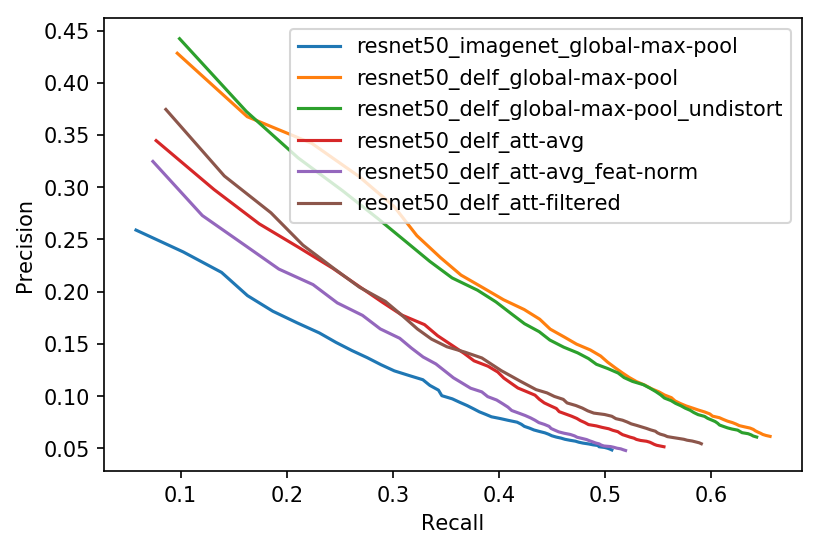

In [8]:
plt.figure(dpi=150)
for e in expers:
    p, r =  get_pr(ref_seq, query_seqs, e, distance_thresh=10, max_num_nn=50, proj_dim=40)
    plt.plot(r, p, label=e);
plt.legend(), plt.xlabel('Recall'), plt.ylabel('Precision');

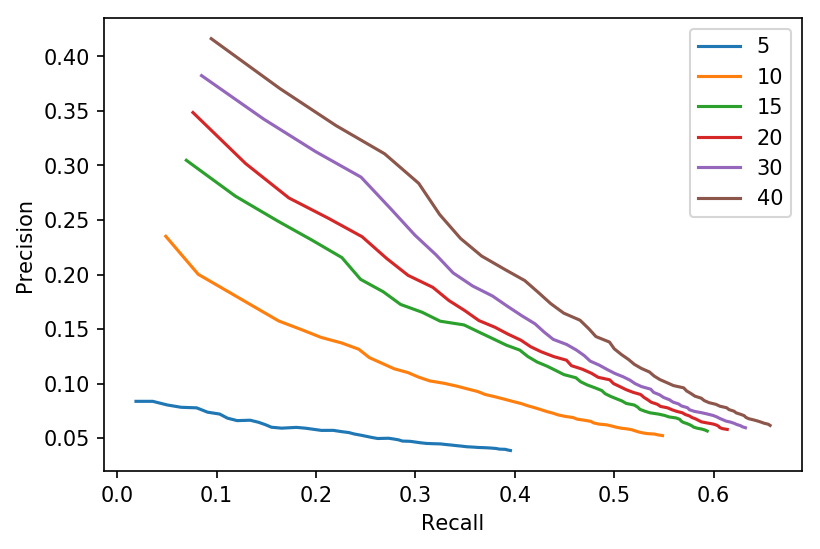

In [9]:
exper = 'resnet50_delf_global-max-pool'
plt.figure(dpi=150)
for d in [5, 10, 15, 20, 30, 40]:
    p, r =  get_pr(ref_seq, query_seqs, exper, distance_thresh=10, max_num_nn=50, proj_dim=d)
    plt.plot(r, p, label=str(d));
plt.legend(), plt.xlabel('Recall'), plt.ylabel('Precision');

# Hit probability

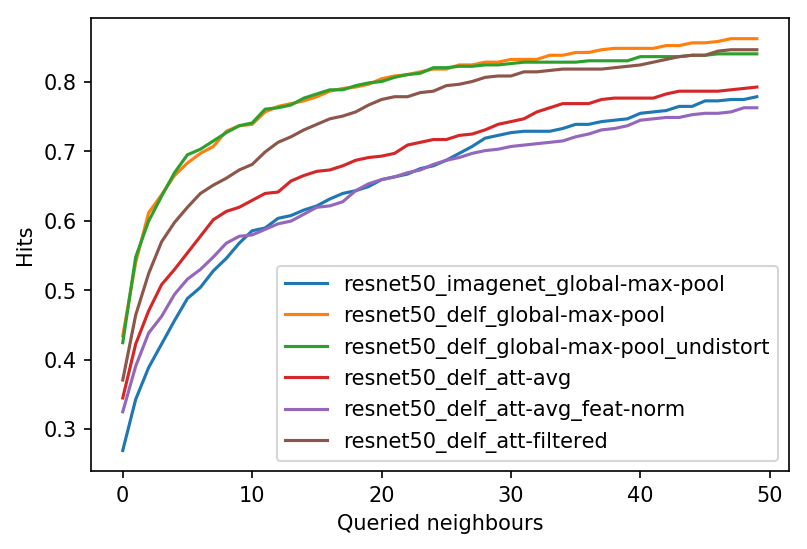

In [10]:
plt.figure(dpi=150)
for e in expers:
    m =  get_match_count(ref_seq, query_seqs, e, distance_thresh=10, max_num_nn=50)
    plt.plot(m, label=e);
plt.legend(), plt.xlabel('Queried neighbours'), plt.ylabel('Hits');

# DELF PR curve

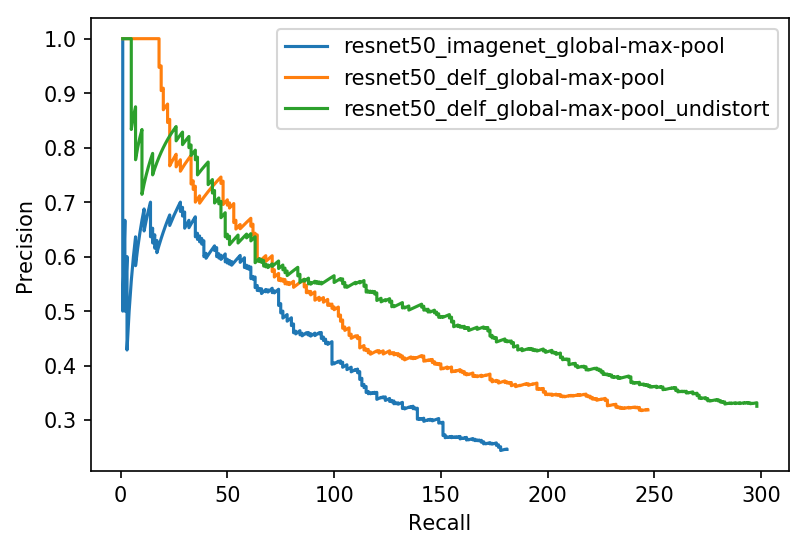

In [11]:
plt.figure(dpi=150)
for e in ['resnet50_imagenet_global-max-pool', 
          'resnet50_delf_global-max-pool', 
          'resnet50_delf_global-max-pool_undistort']:
    p, r =  get_delf_pr(ref_seq, query_seqs, e, distance_thresh=10, max_dist_nn=0.7)
    plt.plot(r, p, label=e);
plt.legend(), plt.xlabel('Recall'), plt.ylabel('Precision');